<a href="https://colab.research.google.com/github/mehdi-or/203B/blob/master/Metadata_making_(MNIST%2C_etc).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Packages

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import csv
from keras.datasets import cifar10, mnist, fashion_mnist
from scipy.spatial.distance import cdist

mounting the Gdrive

In [31]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#@title axillary functions
def my_function (A, B):
  iter = A.shape[0]
  shap = A.shape
  pairwise_dist = np.ones((iter,iter))
  for i in range(iter):
    sample_mat = np.ones((iter,1))*A[i,:]
    dist = np.sqrt(np.mean((sample_mat-B)**2, axis=1))
    if (i%1000) == 0:
      print(i)

    pairwise_dist[:,i] = dist
  return pairwise_dist

def EDM(A,B):
  p1=np.sum(A**2, axis=1)[:, np.newaxis]
  p2=np.sum(B**2, axis=1)
  p3=-2*np.dot(A,B.T)
  return np.round(np.sqrt(p1+p2+p3), 2)

Function for importing the data

In [36]:
def load_data(dim, in_data, net):

    #BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/CIFAR10/BN_dim_'+str(dim)+'.csv', header=None ).values
    #decoded_img = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/CIFAR10/decoded_img_'+str(dim)+'.csv', header=None ).values

    BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_'+net+'/MNIST_fashion/BN_dim_'+str(dim)+'.csv', header=None ).values
    decoded_img = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_'+net+'/MNIST_fashion/decoded_plus_'+str(dim)+'.csv', header=None ).values
    
    #BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_' + net + '/MNIST/BN_dim_'+str(dim)+'.csv', header=None ).values
    #decoded_img = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_' + net + '/MNIST/decoded_num_'+str(dim)+'.csv', header=None ).values
    return(decoded_img, BN)

Function for calculating the between class correlation

In [37]:
def class_diagonal(categ, corr, num_trials, test_label):

  diag_index = range(num_trials) # to find the index of the diagonals of the test-set matrix
  corr_zero = np.copy(corr)
  corr_zero[diag_index, diag_index]=0 # to remove the auto-correlaiton of the trials
  corr_df = pd.DataFrame(corr_zero) # turning it to DataFrame to make my life easier by ALOT
  corr_df.columns=test_label # to name the columns of the correlation
  corr_df.index = test_label # to name the rows of the correlation
  unique_class = np.unique(test_label) # to find what uniqw classes we have in the test-set
  class_matrix_corr = np.zeros((len(unique_class),len(unique_class))) # this is the correlation of the mean values of the classes
  #trial_matrix_corr = np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories
  #trial_matrix_corr =np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories

  for i, row in enumerate(categ):
    for j, column in enumerate(categ):
      #trial_matrix_corr [row, column]=  corr_df.loc[row][column]
      if row==column:
        n_examples = np.sqrt(corr_df.loc[row][column].size) # this is for the case of autocorrelation that we have already put zeros for them so it is fair to not consider them while getting the mean
        class_matrix_corr [i,j] = corr_df.loc[row][column].sum().sum()/(n_examples**2 - n_examples)
      else:
        class_matrix_corr [i,j]= corr_df.loc[row][column].mean().mean()
  return(class_matrix_corr)

Main body of the code

/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/accuVsdim.csv
/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/MNIST_fashion/X_test.csv


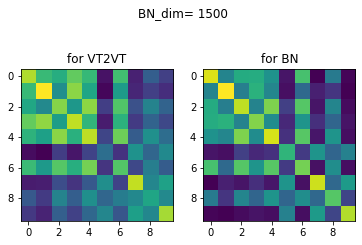

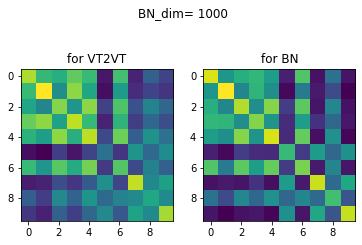

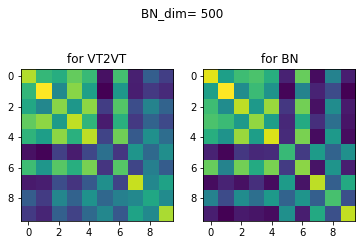

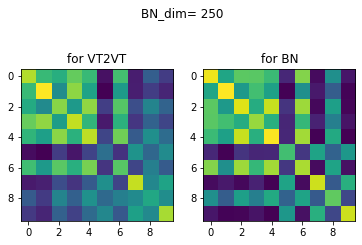

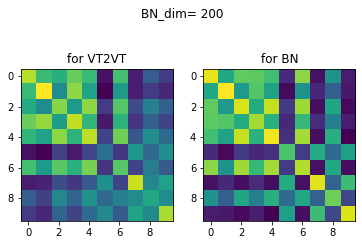

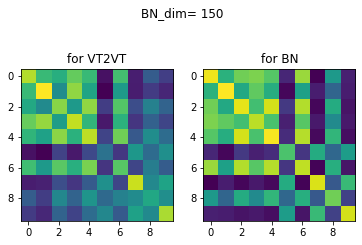

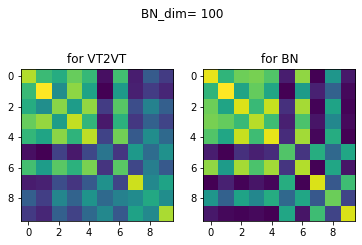

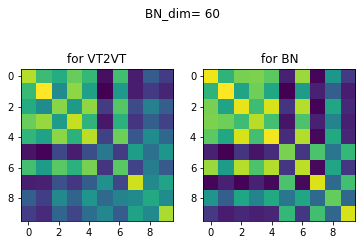

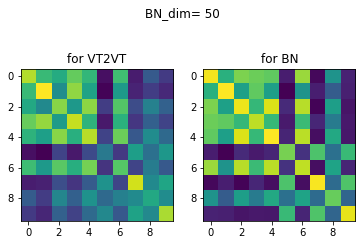

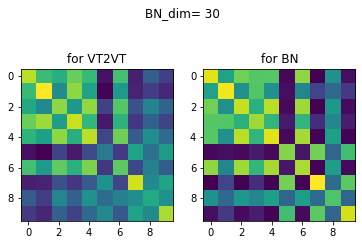

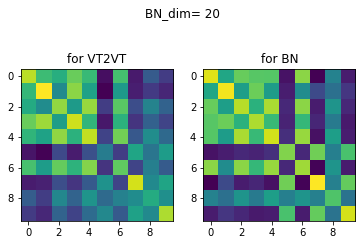

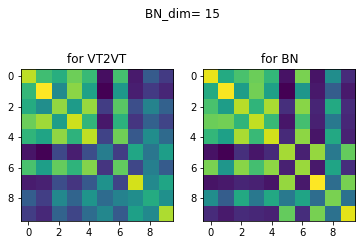

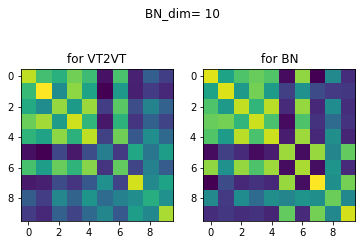

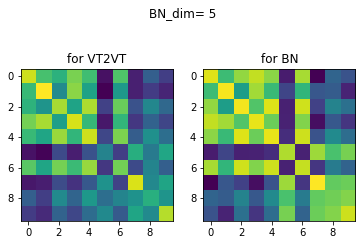

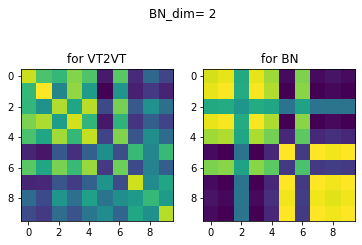

In [38]:
#(X_train, y_train), (X_test2, y_test2) = cifar10.load_data()
(X_train, y_train), (X_test2, y_test2) = fashion_mnist.load_data()
#(X_train, y_train), (X_test2, y_test2) = mnist.load_data()
#accuracy = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/CIFAR10/accuVsdim.csv', header=None ).values
#X_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/CIFAR10/X_test.csv', header=None ).values
net = 'plus'
in_data = 'MNIST_fashion'
source = '/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_'
accuracy = pd.read_csv(source + net +'/' + in_data+ '/accuVsdim.csv', header=None ).values
X_test = pd.read_csv(source + net +'/' + in_data+ '/X_test.csv', header=None ).values
print(source + net +'/' + in_data+ '/accuVsdim.csv')
print(source + net +'/' + in_data+ '/X_test.csv')

y_test = (y_test2.astype(str).T).reshape(10000)
dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2] # mdimension of the BottleNeck

corr_list = [] # a list of correlaion of the decoded examplars (1x15)
class_corr_list = [] # a list of correlation of the categoreies for decoded examplars (1x15)
class_corr_BN_list = [] # a list of correlation of the categoreies for BN(1x15)
categ = np.unique(y_test)
num_trials = len(y_test)
for dim in dims:
    [decoded_img, BN] = load_data(dim, in_data, net)
    corr0 = np.corrcoef(X_test, decoded_img)
    indx = int(corr0.shape[0]/2) 
    corr=corr0[indx:,:indx] # we want only the part of the correlation matrix between the X_test and decoded_img
    corr_BN = np.corrcoef(BN)

    diagonal_corr_mean= np.diagonal(corr).mean()
    corr_list.append(diagonal_corr_mean) # listing the mean of the diagonal of correlation for each dimension
    
    class_corr = class_diagonal(categ, corr, num_trials, y_test)
    class_corr_diagonal_mean = np.diagonal(class_corr).mean()
    #to calculate the off_diag_corr for reconstuct"
    off_diag_indx0 = np.where(~np.eye(class_corr.shape[0],dtype=bool))
    class_corr_off_diag_mean = class_corr[off_diag_indx0].mean()
    class_corr_relative = class_corr_diagonal_mean - class_corr_off_diag_mean
    class_corr_list.append(class_corr_relative) # the mean correlation of the the "digaonal - off_diagonal" based on the categories (not examplars) for BN

     
    class_corr_BN = class_diagonal(categ, corr_BN, num_trials, y_test)
    class_corr_BN_diagonal_mean = np.diagonal(class_corr_BN).mean()
    #to calculate the off_diag_corr_BN"
    off_diag_indx = np.where(~np.eye(class_corr_BN.shape[0],dtype=bool))
    class_corr_BN_off_diag_mean = class_corr_BN[off_diag_indx].mean()
    class_corr_BN_relative = class_corr_BN_diagonal_mean - class_corr_BN_off_diag_mean
    class_corr_BN_list.append(class_corr_BN_relative) # the mean correlation of the the "digaonal - off_diagonal" based on the categories (not examplars) for BN


    fig, (ax1, ax2) = plt.subplots(1,2)
    #ax1.imshow(class_matrix_corr, vmin = 0, vmax =0.9)
    #ax2.imshow(class_matrix_corr_BN, vmin = 0, vmax =0.9)
    ax1.imshow(class_corr)
    ax2.imshow(class_corr_BN)
    fig.suptitle('BN_dim= '+ str(dim))
    ax1.set_title('for VT2VT')
    ax2.set_title('for BN')

In [39]:
class_corr_diagonal_mean

0.7076022058300294

In [40]:
class_corr_off_diag_mean

0.38305243598637706

visualization

/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/plus_meta_data/6th_version/MNIST_fashion_metadata.csv


(0.0, 500.0)

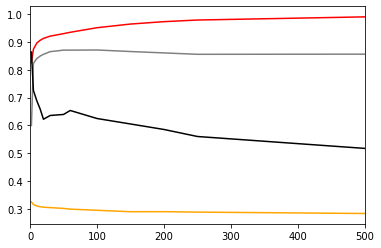

In [41]:
normalized_class_corr_list = (class_corr_list-np.min(class_corr_list))/(np.max(class_corr_list)-np.min(class_corr_list)) # to normalize the corr of reconstructed
normalized_class_corr_BN_list = (class_corr_BN_list-np.min(class_corr_BN_list))/(np.max(class_corr_BN_list)-np.min(class_corr_BN_list)) # to normalize the corr of BN

index_name = ['1500', '1000', '500', '250', '200', '150', '100', '60', '50', '30', '20', '15', '10', '5', '2']
col_name =['dimension','accuracy', 'corr','class_corr', 'class_corr_BN', 'class_corr_norm','class_corr_BN_norm']
dim1 = len(index_name) # number of the diffrent dimesion of BN (here is 15)
dim2 = len(col_name)
AE_plus_CIFAR10 = np.zeros((dim1, dim2))
AE_plus_CIFAR10 = np.asarray([accuracy[:,0], accuracy[:,1], corr_list, class_corr_list, class_corr_BN_list, normalized_class_corr_list, normalized_class_corr_BN_list]).T

print(source + net + '/' + net + '_meta_data/6th_version/' + in_data + '_metadata.csv')  
#DataFrame(AE_plus_CIFAR10,index=index_name, columns=col_name).to_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plain/plain_meta_data/MNIST_metadata.csv') 
DataFrame(AE_plus_CIFAR10,index=index_name, columns=col_name).to_csv(source + net + '/' + net + '_meta_data/6th_version/' + in_data + '_metadata.csv')
#DataFrame(AE_plus_CIFAR10,index=index_name, columns=col_name).to_csv(source + net + '/' + net + '_meta_data/6th_version/' + in_data + '_metadata.csv')
      
plt.figure()

plt.plot(accuracy[:,0], accuracy[:,1], c= 'grey')
plt.plot(accuracy[:,0], corr_list, c='red')
plt.plot(accuracy[:,0], class_corr_list, c='orange')
plt.plot(accuracy[:,0], class_corr_BN_list, c='black')
#plt.plot(accuracy[:,0], normalized_BN, c='blue')
#plt.plot(accuracy[:,0], normalized, c='black')
plt.xlim([0,500])

In [16]:
DataFrame(AE_plus_CIFAR10,index=index_name, columns=col_name).to_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_' + net + '/' + net + '_meta_data/6th_version/' + in_data + '_metadata.csv')